<a href="https://colab.research.google.com/github/KillerStrike17/Deep-Learning-for-Vision-Using-Tensorflow-Keras/blob/master/14.%20ShuffleNets/ShuffleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Thu Dec 12 06:02:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x  #gpu
except Exception:
  pass
import tensorflow as tf

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  #gpu`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
print(tf.__version__)

2.0.0


In [0]:
!git clone https://<username>:<password>@github.com/<github repo>

Cloning into 'rgApi'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 460 (delta 106), reused 0 (delta 0), pack-reused 306
Receiving objects: 100% (460/460), 4.53 MiB | 4.29 MiB/s, done.
Resolving deltas: 100% (285/285), done.


In [0]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.8MB 2.8MB/s 
     |████████████████████████████████| 380.8MB 43kB/s 


In [0]:
from rgApi.tf_utils.tf_utils import data as ds



In [0]:
ds.batch_size=128


In [0]:
ds.get_cifar10_and_create_tfrecords()



Finished 'download_file' in 12.9119 secs
Finished 'download_cifar10_files' in 12.9131 secs
Done
Finished 'extract_cifar10_files' in 1.9102 secs
Finished '_get_file_names' in 0.0000 secs
Generating ./train.tfrecords
Finished 'read_pickle_from_file' in 0.1518 secs
Finished 'read_pickle_from_file' in 0.1446 secs
Finished 'read_pickle_from_file' in 0.1366 secs
Finished 'read_pickle_from_file' in 0.1451 secs
Finished 'read_pickle_from_file' in 0.1399 secs
Finished 'convert_to_tfrecord' in 3.4543 secs
Done!
Generating ./eval.tfrecords
Finished 'read_pickle_from_file' in 0.1415 secs
Finished 'convert_to_tfrecord' in 0.6823 secs
Done!
Finished 'create_tf_records' in 4.1388 secs
Finished 'get_cifar10_and_create_tfrecords' in 18.9632 secs


In [0]:
def aug_fn(image):
  return ds.cutout(ds.flip_left_right(ds.random_pad_crop(image)))

train_ds1=ds.get_train_ds(batch_size=batch_size,shuffle=True,distort=True,distort_fn=aug_fn)

test_ds=ds.get_eval_ds(batch_size=batch_size)

distorting...
Finished 'get_tf_dataset_2' in 4.8119 secs
Finished 'get_tf_dataset_in_batches' in 4.8122 secs
Finished 'get_train_ds' in 4.8124 secs
Finished 'get_tf_dataset' in 0.1655 secs
Finished 'get_tf_dataset_in_batches' in 0.1657 secs
Finished 'get_eval_ds' in 0.1659 secs


In [0]:
test_ds=ds.get_eval_ds(batch_size=batch_size)

Finished 'get_tf_dataset' in 0.0414 secs
Finished 'get_tf_dataset_in_batches' in 0.0419 secs
Finished 'get_eval_ds' in 0.0420 secs


In [0]:
import rgApi.tf_utils.tf_utils.visualize as vz

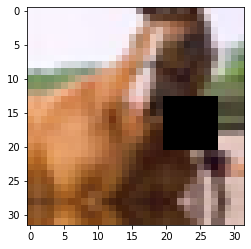

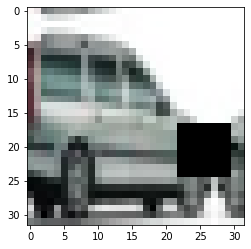

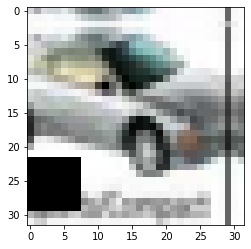

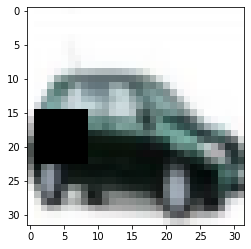

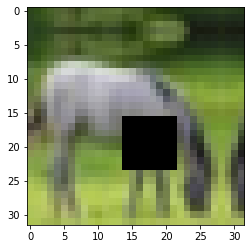

In [0]:
vz.plot_cifar10_files(train_ds1)


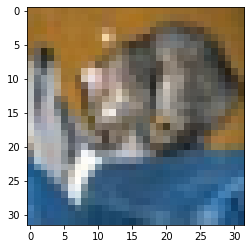

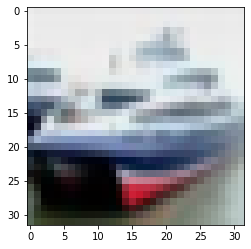

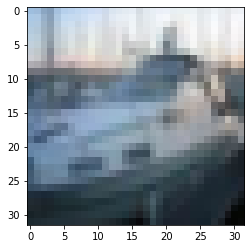

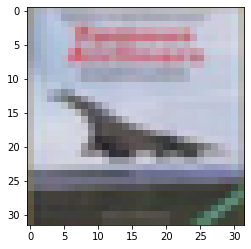

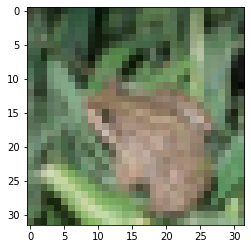

In [0]:
vz.plot_cifar10_files(test_ds)

In [0]:
def _group_conv(x, filters, kernel, stride, groups):
    """
    Group convolution
    
    # Arguments
        x: Tensor, input tensor of with `channels_last` or 'channels_first' data format
        filters: Integer, number of output channels
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
        groups: Integer, number of groups per channel
        
    # Returns
        Output tensor
    """
    
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    in_channels = tf.keras.backend.int_shape(x)[channel_axis]
    
    # number of input channels per group
    nb_ig = in_channels // groups
    # number of output channels per group
    nb_og = filters // groups
    
    gc_list = []
    # Determine whether the number of filters is divisible by the number of groups
    assert filters % groups == 0
    
    for i in range(groups):
        if channel_axis == -1:
            x_group = tf.keras.layers.Lambda(lambda z: z[:, :, :, i * nb_ig: (i + 1) * nb_ig])(x)
        else:
            x_group = tf.keras.layers.Lambda(lambda z: z[:, i * nb_ig: (i + 1) * nb_ig, :, :])(x)
        gc_list.append(tf.keras.layers.Conv2D(filters=nb_og, kernel_size=kernel, strides=stride, 
                              padding='same', use_bias=False)(x_group))
        
    return tf.keras.layers.Concatenate(axis=channel_axis)(gc_list)

def _channel_shuffle(x, groups):
    """
    Channel shuffle layer
    
    # Arguments
        x: Tensor, input tensor of with `channels_last` or 'channels_first' data format
        groups: Integer, number of groups per channel
        
    # Returns
        Shuffled tensor
    """
    
    if tf.keras.backend.image_data_format() == 'channels_last':
        height, width, in_channels = tf.keras.backend.int_shape(x)[1:]
        channels_per_group = in_channels // groups
        pre_shape = [-1, height, width, groups, channels_per_group]
        dim = (0, 1, 2, 4, 3)
        later_shape = [-1, height, width, in_channels]
    else:
        in_channels, height, width = tf.keras.backend.int_shape(x)[1:]
        channels_per_group = in_channels // groups
        pre_shape = [-1, groups, channels_per_group, height, width]
        dim = (0, 2, 1, 3, 4)
        later_shape = [-1, in_channels, height, width]

    x = tf.keras.layers.Lambda(lambda z: tf.keras.backend.reshape(z, pre_shape))(x)
    x = tf.keras.layers.Lambda(lambda z: tf.keras.backend.permute_dimensions(z, dim))(x)  
    x = tf.keras.layers.Lambda(lambda z: tf.keras.backend.reshape(z, later_shape))(x)

    return x

def _shufflenet_unit(inputs, filters, kernel, stride, groups, stage, bottleneck_ratio=0.25):
    """
    ShuffleNet unit
    
    # Arguments
        inputs: Tensor, input tensor of with `channels_last` or 'channels_first' data format
        filters: Integer, number of output channels
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
        groups: Integer, number of groups per channel
        stage: Integer, stage number of ShuffleNet
        bottleneck_channels: Float, bottleneck ratio implies the ratio of bottleneck channels to output channels
         
    # Returns
        Output tensor
        
    # Note
        For Stage 2, we(authors of shufflenet) do not apply group convolution on the first pointwise layer 
        because the number of input channels is relatively small.
    """
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    in_channels = tf.keras.backend.int_shape(inputs)[channel_axis]
    bottleneck_channels = int(filters * bottleneck_ratio)
    
    if stage == 2:
        x = tf.keras.layers.Conv2D(filters=bottleneck_channels, kernel_size=kernel, strides=1,
                   padding='same', use_bias=False)(inputs)
    else:
        x = _group_conv(inputs, bottleneck_channels, (1, 1), 1, groups)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis)(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = _channel_shuffle(x, groups)
    
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=kernel, strides=stride, depth_multiplier=1, 
                        padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis)(x)
      
    if stride == 2:
        x = _group_conv(x, filters - in_channels, (1, 1), 1, groups)
        x = tf.keras.layers.BatchNormalization(axis=channel_axis)(x)
        avg = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=2, padding='same')(inputs)
        x = tf.keras.layers.Concatenate(axis=channel_axis)([x, avg])
    else:
        x = _group_conv(x, filters, (1, 1), 1, groups)
        x = tf.keras.layers.BatchNormalization(axis=channel_axis)(x)
        x = tf.keras.layers.add([x, inputs])
    
    return x

def _stage(x, filters, kernel, groups, repeat, stage):
    """
    Stage of ShuffleNet
    
    # Arguments
        x: Tensor, input tensor of with `channels_last` or 'channels_first' data format
        filters: Integer, number of output channels
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
        groups: Integer, number of groups per channel
        repeat: Integer, total number of repetitions for a shuffle unit in every stage
        stage: Integer, stage number of ShuffleNet
        
    # Returns
        Output tensor
    """
    x = _shufflenet_unit(x, filters, kernel, 2, groups, stage)
    
    for i in range(1, repeat):
        x = _shufflenet_unit(x, filters, kernel, 1, groups, stage)
        
    return x
    
def ShuffleNet(input_shape, classes):
    """
    ShuffleNet architectures
    
    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor
        k: Integer, number of classes to predict
        
    # Returns
        A keras model
    """
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.UpSampling2D((7,7))(inputs)
    # x = tf.keras.layers.UpSampling2D((2,2))(x)
    # x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(24, (3, 3), strides=2, padding='same', use_bias=True, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    
    x = _stage(x, filters=384, kernel=(3, 3), groups=8, repeat=4, stage=2)
    x = _stage(x, filters=768, kernel=(3, 3), groups=8, repeat=8, stage=3)
    x = _stage(x, filters=1536, kernel=(3, 3), groups=8, repeat=4, stage=4)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dense(classes)(x)
    predicts = tf.keras.layers.Activation('softmax')(x)
    
    model = tf.keras.Model(inputs, predicts)
    
    return model

In [0]:
model = ShuffleNet((32, 32, 3), 10)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
up_sampling2d (UpSampling2D)    (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 24) 672         up_sampling2d[0][0]              
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 24)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['accuracy']
              )

In [0]:
import numpy as np
batch_size=128
model.fit(train_ds1,epochs=5, steps_per_epoch=np.ceil(50000/batch_size), 
          validation_data=test_ds, validation_steps=np.ceil(10000/batch_size),
          verbose=1)

Train for 391.0 steps, validate for 79.0 steps
Epoch 1/5
391/391 [==============================] - 398s 1s/step - loss: 1.1331 - accuracy: 0.5960 - val_loss: 1.3705 - val_accuracy: 0.5373
Epoch 2/5
391/391 [==============================] - 398s 1s/step - loss: 1.0386 - accuracy: 0.6294 - val_loss: 1.2326 - val_accuracy: 0.5993
Epoch 3/5
391/391 [==============================] - 398s 1s/step - loss: 0.9794 - accuracy: 0.6536 - val_loss: 1.0574 - val_accuracy: 0.6286
Epoch 4/5
391/391 [==============================] - 399s 1s/step - loss: 0.9222 - accuracy: 0.6758 - val_loss: 1.2618 - val_accuracy: 0.6185
Epoch 5/5
391/391 [==============================] - 399s 1s/step - loss: 0.8810 - accuracy: 0.6874 - val_loss: 1.0096 - val_accuracy: 0.6497


In [0]:
res=vz.get_misclassified_images(model,test_ds)

79/79 [==============================] - 26s 333ms/step


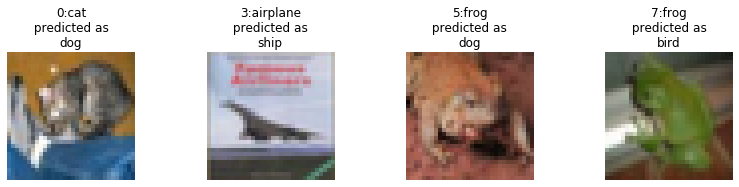

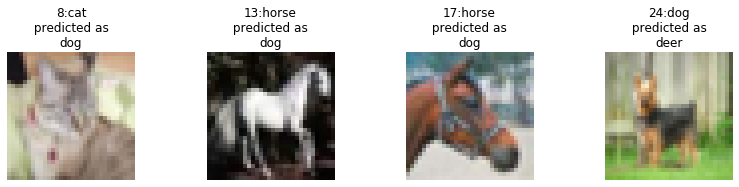

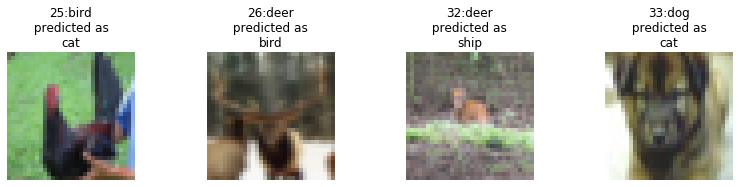

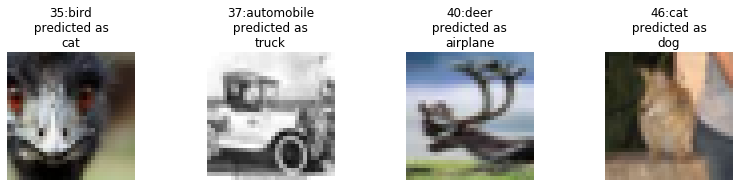

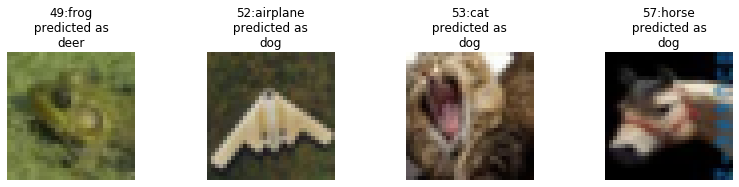

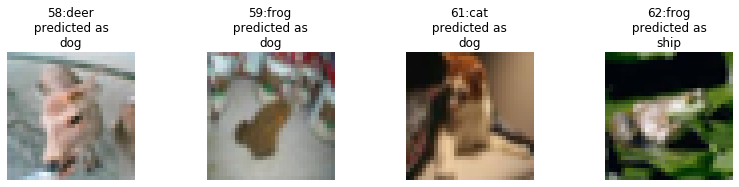

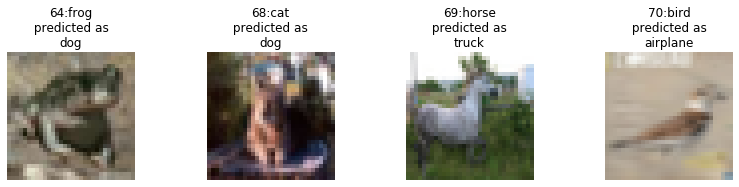

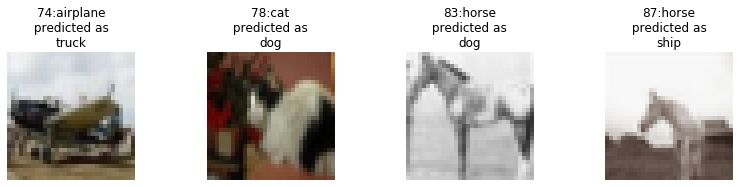

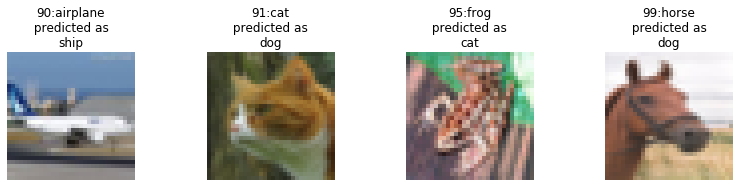

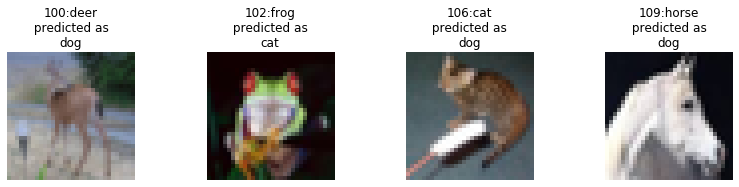

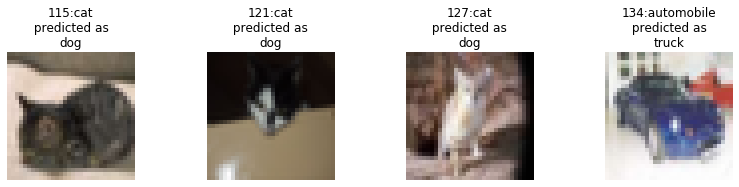

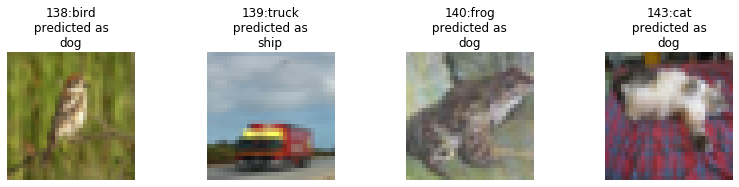

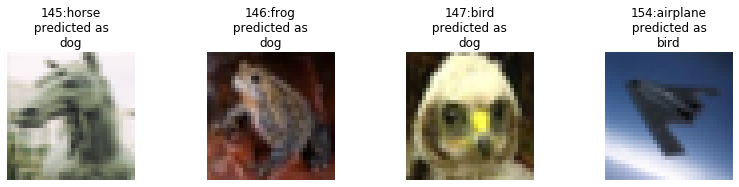

In [0]:
vz.plot_misclassified_images(res[0],res[1],res[2],res[3],52)